In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta, RMSprop, Adam
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import time

Using TensorFlow backend.


In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
model = models.get_luke_model_140_2(input_shape=(140,140,1))
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,140,augment_valid,augment_valid)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
sample_gap=10
epochs=30
stepsperepoch=100
k = 5
video_path = '/cropped_video141'


start = time.time()    

augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,140,augment_valid,augment_valid)

#prep cells for feeding into CNN
control_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant'))
sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible'))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

print(len(control_cells_label))
print(len(sus_cells_label))

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)
train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
print(len(train_labels))
print(len(test_labels))

im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

# now all cells are labeled, add together to send to kfold as we don't need to reserve a train set
all_labels = train_labels + test_labels
random.shuffle(all_labels)

validate_steps = len(im_paths_test)//32
model = models.get_luke_model_140_2(input_shape=(140,140,1))

#get kfold predictions from training set 
train_preds, kfold_val_acc, kfold_acc, kfold_val_loss = cnn_module.k_fold_train(all_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,k)


end = time.time()
run_time = end-start
print('time =', run_time)    

311
351
594
68
fold 1
Epoch 1/30
100/100 [==============================] - 15s 153ms/step - loss: 0.9194 - acc: 0.5866 - val_loss: 0.6031 - val_acc: 0.6999
Epoch 2/30
100/100 [==============================] - 9s 86ms/step - loss: 0.6223 - acc: 0.6406 - val_loss: 0.5980 - val_acc: 0.6877
Epoch 3/30
100/100 [==============================] - 8s 84ms/step - loss: 0.6063 - acc: 0.6462 - val_loss: 0.5734 - val_acc: 0.7210
Epoch 4/30
100/100 [==============================] - 7s 69ms/step - loss: 0.5844 - acc: 0.6597 - val_loss: 0.5585 - val_acc: 0.7475
Epoch 5/30
100/100 [==============================] - 6s 59ms/step - loss: 0.5496 - acc: 0.7056 - val_loss: 0.5060 - val_acc: 0.7437
Epoch 6/30
100/100 [==============================] - 6s 58ms/step - loss: 0.5569 - acc: 0.6891 - val_loss: 0.5563 - val_acc: 0.6827
Epoch 7/30
100/100 [==============================] - 6s 58ms/step - loss: 0.5341 - acc: 0.7106 - val_loss: 0.5698 - val_acc: 0.6999
Epoch 8/30
100/100 [=========================

Epoch 2/30
100/100 [==============================] - 6s 58ms/step - loss: 0.6292 - acc: 0.6488 - val_loss: 0.6429 - val_acc: 0.6052
Epoch 3/30
100/100 [==============================] - 6s 58ms/step - loss: 0.5819 - acc: 0.6713 - val_loss: 0.6344 - val_acc: 0.5955
Epoch 4/30
100/100 [==============================] - 6s 57ms/step - loss: 0.5742 - acc: 0.6894 - val_loss: 0.5967 - val_acc: 0.6490
Epoch 5/30
100/100 [==============================] - 6s 57ms/step - loss: 0.5315 - acc: 0.7147 - val_loss: 0.5949 - val_acc: 0.6780
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.5361 - acc: 0.7147 - val_loss: 0.5678 - val_acc: 0.6709
Epoch 7/30
100/100 [==============================] - 6s 58ms/step - loss: 0.5155 - acc: 0.7244 - val_loss: 0.5792 - val_acc: 0.6397
Epoch 8/30
100/100 [==============================] - 6s 58ms/step - loss: 0.5061 - acc: 0.7359 - val_loss: 0.5812 - val_acc: 0.6629
Epoch 9/30
100/100 [==============================] - 6s 57ms/step - 

In [6]:
result = [train_preds, kfold_val_acc, kfold_acc, kfold_val_loss, run_time]
print(result)

[{'/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo000.tiff': array([1.1438329e-10, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo010.tiff': array([9.4823635e-11, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo020.tiff': array([2.6068483e-10, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo030.tiff': array([2.4986787e-11, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo040.tiff': array([7.5084244e-11, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo050.tiff': array([2.0291162e-10, 1.0000000e+00], dtype=float32), '/home/ubuntu/data/susceptible/sample15/cell226/cropped_video141/croppedvideo060.tiff': array([1.9457289e-10, 1.0000000e+00], dtype=float32), '/ho

In [7]:
#pickle.dump(result, open('/home/ubuntu/data/code/2dCNN/cropsize140x140.p','wb'))

In [17]:
import pickle
result80 = pickle.load(open('/home/ubuntu/data/code/2dCNN/rc_model1_lr001.p','rb'))
val_acc = result80[1]
#time80 = result_all[5]
val_loss_avg = np.avg( val_acc, axis = 0)
#kfold_loss = result_all[4]
print(val_loss_avg)

AttributeError: module 'numpy' has no attribute 'avg'

In [5]:
import numpy as np
val_acc_avg = np.mean( result80, axis = 0)
print('val acc: ', val_acc_avg)

acc_avg = np.mean( result80, axis = 0)
print('acc: ',acc_avg)

val_loss_avg = np.mean( result80, axis = 0)
print('val loss: ',val_loss_avg)

TypeError: unsupported operand type(s) for +: 'dict' and 'list'

(0.5, 1)

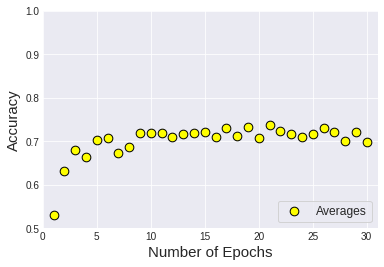

In [12]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

(0.4434396849978068, 0.9042789751925617)

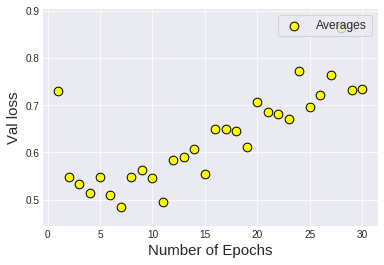

In [18]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_loss_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='upper right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Val loss', size = 15)
plt.xticks(np.arange(0, 35, 5))
#plt.xlim(0,31)
plt.ylim()

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

(0.5, 1.05)

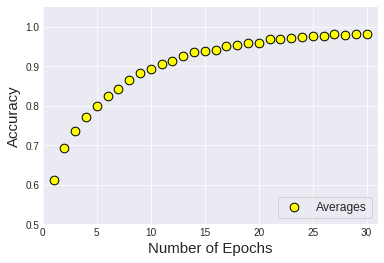

In [19]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1.05)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_acc.png', dpi=500)

In [1]:
import pickle 
kfold_val_acc, all_preds = pickle.load(open('/home/ubuntu/data/code/3dCNN/3d_kfold_final_ceph4.p','rb'))

In [5]:
print(kfold_val_acc)

[[0.6723856234959528, 0.6552287576099237, 0.728758169812899, 0.5620915032923222, 0.7132352948480961, 0.832516339698843, 0.8537581698859439, 0.4999999994156407, 0.8129084977303066, 0.8071895411932001, 0.800653594308624, 0.8186274528065148, 0.828431372183795, 0.8562091494015619, 0.7785947717287961, 0.8161764703691006, 0.8227124187145748, 0.8790849676611376, 0.8080065350468252, 0.842320262290099, 0.8055555556772971, 0.9207516338895348, 0.7704248375021944, 0.8218954242765903, 0.7973856206472013], [0.6715686273048905, 0.6617647069780266, 0.7720588244789955, 0.8300653609867189, 0.7687908500871238, 0.8455882350749829, 0.7753267982865081, 0.8472222230744129, 0.7647058819146717, 0.8316993450417238, 0.7892156853979709, 0.8635620914545714, 0.7393790839203432, 0.8104575147815779, 0.7598039205459988, 0.8161764702960557, 0.8235294114725262, 0.8259803926681771, 0.7965686270127109, 0.8055555563347012, 0.7042483640652076, 0.7728758158490938, 0.8039215684813612, 0.7802287584134177, 0.8080065362885887], 

In [12]:
kfold_val_acc = [[0.6723856234959528, 0.6552287576099237, 0.728758169812899, 0.5620915032923222, 0.7132352948480961, 0.832516339698843, 0.8537581698859439, 0.7999999994156407, 0.8129084977303066, 0.8071895411932001, 0.800653594308624, 0.8186274528065148, 0.828431372183795, 0.8562091494015619, 0.7785947717287961, 0.8161764703691006, 0.8227124187145748, 0.8790849676611376, 0.8080065350468252, 0.842320262290099, 0.8055555556772971, 0.9207516338895348, 0.7704248375021944, 0.8218954242765903, 0.7973856206472013], [0.6715686273048905, 0.6617647069780266, 0.7720588244789955, 0.8300653609867189, 0.7687908500871238, 0.8455882350749829, 0.7753267982865081, 0.8472222230744129, 0.7647058819146717, 0.8316993450417238, 0.7892156853979709, 0.8635620914545714, 0.7393790839203432, 0.8104575147815779, 0.7598039205459988, 0.8161764702960557, 0.8235294114725262, 0.8259803926681771, 0.7965686270127109, 0.8055555563347012, 0.7042483640652076, 0.7728758158490938, 0.8039215684813612, 0.7802287584134177, 0.8080065362885887], [0.6928104596833388, 0.720588234198444, 0.663398693808738, 0.7500000008034939, 0.68055555735733, 0.7973856211585157, 0.7442810467499144, 0.6013071900051014, 0.68366013176593126, 0.8169934659027586, 0.6593137245406123, 0.7622549015955598, 0.6421568645712208, 0.7426470605035623, 0.7254901973201948, 0.7539215691387653, 0.8447712422439865, 0.8178104591720244, 0.6209150329232216, 0.7818627469972068, 0.8104575180685988, 0.7393790866230049, 0.800653594308624, 0.7965686276701152, 0.8292483654530609], [0.6576797370524967, 0.7712418291644723, 0.8496732021517613, 0.7205882324453663, 0.7908496703295147, 0.8406862753863428, 0.78839869220175, 0.8031045739703319, 0.7499999995617306, 0.8014705877239797, 0.7843137248327919, 0.7328431357940038, 0.7736928091914046, 0.8194444433731192, 0.7851307181751027, 0.6952614367884749, 0.7532679714700755, 0.7745098031911195, 0.7933006533512882, 0.7696078409459076, 0.7802287572446991, 0.8382352941176471, 0.7777777785325751, 0.7736928098488087, 0.7736928099948986], [0.6903594765885204, 0.7573529404460215, 0.7328431374740367, 0.7214052280520692, 0.6968954234000515, 0.7165032657338124, 0.8300653606214944, 0.6560457508061447, 0.677287579094078, 0.6805555545816234, 0.7434640519467055, 0.8243464029156694, 0.7132352931680632, 0.7810457495643812, 0.8235294099385831, 0.807189540535796, 0.6952614348893073, 0.7957516330860409, 0.8398692804370441, 0.8341503236808029, 0.6911764692734269, 0.7982026120172996, 0.8161764698577862, 0.6748366029385258, 0.7328431360131386]]

In [13]:
result = kfold_val_acc, all_preds
pickle.dump(result, open('/home/ubuntu/data/code/3dCNN/3d_kfold_final_ceph5.p','wb'))

[0.67696078 0.71323529 0.74934641 0.71683007 0.73006536 0.80653595
 0.79836601 0.74153595 0.73771242 0.7875817  0.75539216 0.8003268
 0.73937908 0.80196078 0.7745098  0.7777451  0.7879085  0.81862745
 0.77173203 0.80669935 0.75833333 0.81388889 0.79379085 0.76944444
 0.78823529] [0.01305759 0.0477057  0.06109757 0.08706498 0.04249497 0.04807477
 0.03906015 0.09523761 0.0511994  0.05448556 0.05177341 0.0467206
 0.06203773 0.03814791 0.03209859 0.0473118  0.05567222 0.03515541
 0.07718336 0.02834202 0.05071786 0.06243755 0.01704836 0.05014343
 0.03297416]


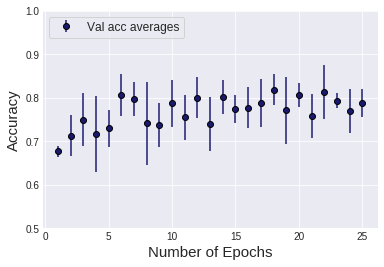

In [14]:
#plotting val acc averages with 
val_acc_avg = np.mean(kfold_val_acc, axis = 0)
val_acc_std = np.std(kfold_val_acc, axis = 0)
x_vals = np.arange(1,26)
print(val_acc_avg, val_acc_std)
plt.style.use('seaborn-darkgrid')
plt.errorbar(x_vals, val_acc_avg,val_acc_std, color='midnightblue', linewidth=2.5, elinewidth=1.5,fmt='o',mec='black', label = 'Val acc averages')
plt.legend(loc='upper left',frameon=True, fontsize=12)
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
#plt.xticks(np.arange(0, 25, 5))
plt.ylim(0.5,1)

plt.show()

In [26]:
print('Accuracy')
(94+139)/(94+139+55)

Accuracy


0.8090277777777778

In [ ]:
test_predictions

In [ ]:
1264+176+95+745

In [ ]:
2009/2280

In [ ]:
sample_gap